In [2]:
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
import json
from zipfile import ZipFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
import gradio as gr
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler

In [6]:
# with ZipFile("pictures V2.zip", 'r') as zip_ref:
#     zip_ref.extractall()

In [6]:
base_dir = 'pictures'

(140, 140, 3)


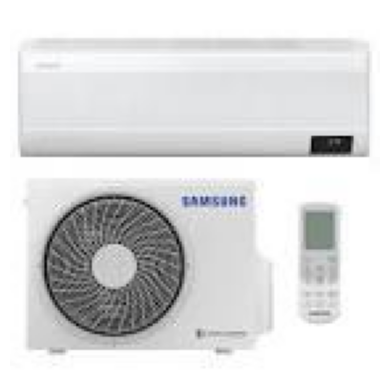

In [7]:
image_path = "pictures/conditioner/air conditioner_6.jpg"
img = mpimg.imread(image_path)

print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
def verify_and_clean_dataset(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except (IOError, SyntaxError):
                print(f"Removing corrupted file: {file_path}")
                os.remove(file_path)
verify_and_clean_dataset(base_dir)

In [9]:
img_size = 224
batch_size = 32

In [10]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [11]:
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 640 images belonging to 16 classes.


In [12]:
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 159 images belonging to 16 classes.


In [13]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25)) 

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25)) 

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25)) 

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))  

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5)) 

model.add(layers.Dense(train_generator.num_classes, activation='softmax'))


optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=60,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/60
20/20 [==============================] - 10s 120ms/step - loss: 3.0398 - accuracy: 0.1078 - val_loss: 2.7584 - val_accuracy: 0.1406
Epoch 2/60
20/20 [==============================] - 2s 100ms/step - loss: 2.7213 - accuracy: 0.1437 - val_loss: 2.7315 - val_accuracy: 0.1641
Epoch 3/60
20/20 [==============================] - 2s 100ms/step - loss: 2.6091 - accuracy: 0.1672 - val_loss: 2.7058 - val_accuracy: 0.1953
Epoch 4/60
20/20 [==============================] - 2s 102ms/step - loss: 2.5078 - accuracy: 0.1969 - val_loss: 2.6441 - val_accuracy: 0.1562
Epoch 5/60
20/20 [==============================] - 2s 102ms/step - loss: 2.3171 - accuracy: 0.2688 - val_loss: 2.4440 - val_accuracy: 0.2188
Epoch 6/60
20/20 [==============================] - 2s 103ms/step - loss: 2.0819 - accuracy: 0.3438 - val_loss: 2.2169 - val_accuracy: 0.2812
Epoch 7/60
20/20 [==============================] - 2s 100ms/step - loss: 1.8242 - accuracy: 0.4234 - val_loss: 2.0459 - val_accuracy: 0.3750
Epoch

In [24]:
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
4/4 [==============================] - 0s 30ms/step - loss: 2.0111 - accuracy: 0.7266
Validation Accuracy: 72.66%


In [26]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array


def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name


In [27]:
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [28]:
class_indices

{0: 'blendr',
 1: 'conditioner',
 2: 'fen',
 3: 'fridge',
 4: 'gaz',
 5: 'laptop',
 6: 'laundry',
 7: 'microwave',
 8: 'planshet',
 9: 'radiator',
 10: 'smartphone',
 11: 'tefal',
 12: 'tel',
 13: 'tv',
 14: 'ventilyator',
 15: 'watch'}

In [29]:
json.dump(class_indices, open('class_indices.json', 'w'))

In [30]:
image_path = 'download.jpg'

predicted_class_name = predict_image_class(model, image_path, class_indices)

print("Predicted class name:", predicted_class_name)

1/1 [==============================] - 1s 555ms/step
Predicted class name: radiator


In [31]:
model.save('recommend.h5')

In [5]:
import tensorflow as tf
import numpy as np
from PIL import Image
import gradio as gr
import requests
from bs4 import BeautifulSoup


class_indices = {
    0: 'blender', 1: 'conditioner', 2: 'fen', 3: 'muzlatgich', 4: 'gaz', 5: 'acer', 
    6: 'kir yuvish mashinasi', 7: "Mikroto'lqinli pech", 8: 'planshet', 9: 'isitgich', 10: 'apple iphone', 
    11: 'elektr choynak', 12: 'nokia', 13: 'televizor', 14: 'ventilyator', 15: 'watch'
}


model = tf.keras.models.load_model('recommend.h5')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


def load_and_preprocess_image(image, target_size=(224, 224)):
    img = Image.open(image)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array

def predict_image_class(image):
    preprocessed_img = load_and_preprocess_image(image)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    confidence_score = np.max(predictions) * 100

    if confidence_score > 90:
        return predicted_class_name, confidence_score
    else:
        return "No category", 0


def search_and_display_cards(category):
    search_url = f"https://elmakon.uz/uz/?match=all&subcats=Y&pshort=Y&pfull=Y&pname=Y&pkeywords=Y&search_performed=Y&q={category}&dispatch=products.search"
    print(f"Searching for category: {category}")
    response = requests.get(search_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    

    cards = soup.find_all('div', class_='ut2-gl__item', limit=3)
    card_info = []
    for card in cards:
        try:
            title_tag = card.find('a', class_='product-title')
            title = title_tag.text.strip() if title_tag else "No title found"
            price_tag = card.find('span', class_='ty-price-num')
            price = price_tag.text.strip() if price_tag else "No price found"
            image_tag = card.find('img', class_='ty-pict')
            image_url = image_tag['src'] if image_tag else None
            full_image_url = f"https://elmakon.uz{image_url}" if image_url and image_url.startswith('/') else image_url
            card_info.append((title, price, full_image_url))
            print(f"Title: {title}, Price: {price}, Image URL: {full_image_url}")
        except Exception as e:
            print(f"Error parsing card: {e}")
    return card_info


def predict_and_search(image):
    category_name, confidence_score = predict_image_class(image)
    if category_name == "No category":
        return "No category detected", None, None, None, None, None, None, None, None, None
    else:
        search_results = search_and_display_cards(category_name)
        if not search_results:
            return "No products found", None, None, None, None, None, None, None, None, None
        
        result1 = search_results[0] if len(search_results) > 0 else ("", "", "")
        result2 = search_results[1] if len(search_results) > 1 else ("", "", "")
        result3 = search_results[2] if len(search_results) > 2 else ("", "", "")
        
        return (
            f"Predicted Category: {category_name} ({confidence_score:.2f}%)",
            result1[2], result1[0], result1[1],
            result2[2], result2[0], result2[1],
            result3[2], result3[0], result3[1]
        )

gr.Interface(
    fn=predict_and_search,
    inputs=gr.Image(type="filepath"),
    outputs=[
        gr.Textbox(label="Output"),
        gr.Image(label="Top Card 1 Image"),
        gr.Textbox(label="Top Card 1 Title"),
        gr.Textbox(label="Top Card 1 Price"),
        gr.Image(label="Top Card 2 Image"),
        gr.Textbox(label="Top Card 2 Title"),
        gr.Textbox(label="Top Card 2 Price"),
        gr.Image(label="Top Card 3 Image"),
        gr.Textbox(label="Top Card 3 Title"),
        gr.Textbox(label="Top Card 3 Price")
    ]
).launch(share=True)


Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
